In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

2024-01-15 23:55:46.417161: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 23:55:46.692412: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 23:55:46.692541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 23:55:46.725516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 23:55:46.801553: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 23:55:46.803074: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-01-15 23:55:55,734 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [6]:
#fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
idxs_sam = [idx_sam for idx_sam in np.arange(0, 50) if isfile(f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5')]
# get first N for this notebook
idxs_sam = idxs_sam[:30]
n_sams = len(idxs_sam)
fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5' for idx_sam in idxs_sam]

In [7]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [9]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [10]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [11]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [12]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [13]:
smf_arr = []
nbar_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    
        
        nbar_arr.append(len(mstar_raw)/vol_Mpc)

/tmp/ipykernel_321670/292810891.py:7: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [14]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [15]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [16]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_321670/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

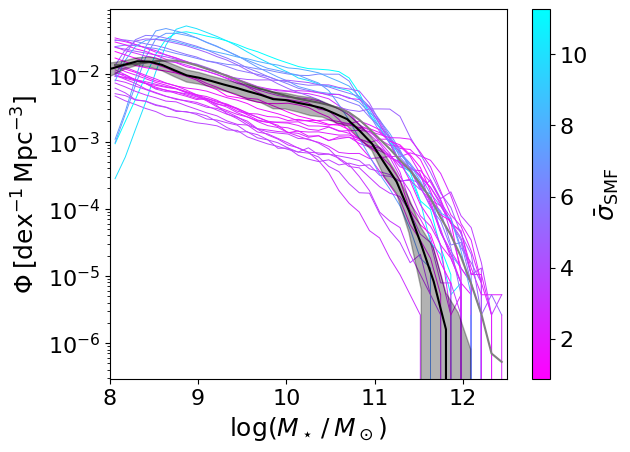

In [17]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [18]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.01,
                  'kmax':1.0,
                  'nbins':16,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [19]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [20]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2024-01-15 23:55:57,020 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:55:57,324 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.216 secs
2024-01-15 23:55:57,333 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2024-01-15 23:55:57,412 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.015 secs
2024-01-15 23:55:57,414 bacco.statistics :  setting the grid 256 True
2024-01-15 23:55:57,415 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:55:57,417 bacco.statistics : starting deposit 1
2024-01-15 23:55:57,487 bacco.statistics :  mesh done in 0.0722 s
2024-01-15 23:55:57,488 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:55:57,690 bacco.statistics :  done compute.power
2024-01-15 23:55:57,704 bacco.statistics :  power done in 0.685 s
2024-01-15 23:55:57,738 bacco.statistics : Computing the power spectrum with ngrid

bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 174733 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 174733 (grid1) 174733 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.072340 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.069496 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000112 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 135120 particles (1 wit

2024-01-15 23:55:59,162 bacco.statistics :  done compute.power
2024-01-15 23:55:59,163 bacco.statistics :  power done in 0.222 s
2024-01-15 23:55:59,185 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:55:59,187 bacco.statistics :  setting the grid 256 True
2024-01-15 23:55:59,189 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:55:59,190 bacco.statistics : starting deposit 1
2024-01-15 23:55:59,244 bacco.statistics :  mesh done in 0.055 s
2024-01-15 23:55:59,249 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:55:59,449 bacco.statistics :  done compute.power
2024-01-15 23:55:59,450 bacco.statistics :  power done in 0.265 s
2024-01-15 23:55:59,469 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:55:59,471 bacco.statistics :  setting the grid 256 True
2024-01-15 23:55:59,472 bacco.statistics : Computing cic mesh with ngrid=256 

actor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 176420 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 176420 (grid1) 176420 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.063290 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.064326 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000090 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 151754 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxs

2024-01-15 23:56:00,630 bacco.statistics :  done compute.power
2024-01-15 23:56:00,631 bacco.statistics :  power done in 0.292 s
2024-01-15 23:56:00,647 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:56:00,650 bacco.statistics :  setting the grid 256 True
2024-01-15 23:56:00,650 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:56:00,651 bacco.statistics : starting deposit 1
2024-01-15 23:56:00,733 bacco.statistics :  mesh done in 0.0827 s
2024-01-15 23:56:00,734 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:00,956 bacco.statistics :  done compute.power
2024-01-15 23:56:00,968 bacco.statistics :  power done in 0.321 s
2024-01-15 23:56:00,988 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:56:00,990 bacco.statistics :  setting the grid 256 True
2024-01-15 23:56:00,990 bacco.statistics : Computing cic mesh with ngrid=256

h : allocating 128.0 Mb
bacco.mesh : binning of 154917 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 154917 (grid1) 154917 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.072124 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.083114 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000096 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 166849 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposi

2024-01-15 23:56:02,078 bacco.statistics :  mesh done in 0.0711 s
2024-01-15 23:56:02,082 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:02,265 bacco.statistics :  done compute.power
2024-01-15 23:56:02,266 bacco.statistics :  power done in 0.262 s
2024-01-15 23:56:02,287 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:56:02,289 bacco.statistics :  setting the grid 256 True
2024-01-15 23:56:02,289 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:56:02,290 bacco.statistics : starting deposit 1
2024-01-15 23:56:02,359 bacco.statistics :  mesh done in 0.0699 s
2024-01-15 23:56:02,361 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:02,544 bacco.statistics :  done compute.power
2024-01-15 23:56:02,545 bacco.statistics :  power done in 0.258 s
2024-01-15 23:56:02,579 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

les (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 152059 (grid1) 152059 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.051544 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.067631 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000087 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 164702 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_

2024-01-15 23:56:03,516 bacco.statistics :  mesh done in 0.0747 s
2024-01-15 23:56:03,517 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:03,691 bacco.statistics :  done compute.power
2024-01-15 23:56:03,692 bacco.statistics :  power done in 0.254 s
2024-01-15 23:56:03,714 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:56:03,717 bacco.statistics :  setting the grid 256 True
2024-01-15 23:56:03,722 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:56:03,723 bacco.statistics : starting deposit 1
2024-01-15 23:56:03,801 bacco.statistics :  mesh done in 0.0793 s
2024-01-15 23:56:03,804 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:03,974 bacco.statistics :  done compute.power
2024-01-15 23:56:03,976 bacco.statistics :  power done in 0.262 s
2024-01-15 23:56:04,008 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

wer : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 172757 (grid1) 172757 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.049843 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.078424 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000194 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 170257 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 

2024-01-15 23:56:05,059 bacco.statistics :  mesh done in 0.079 s
2024-01-15 23:56:05,061 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:05,286 bacco.statistics :  done compute.power
2024-01-15 23:56:05,288 bacco.statistics :  power done in 0.311 s
2024-01-15 23:56:05,317 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2024-01-15 23:56:05,321 bacco.statistics :  setting the grid 256 True
2024-01-15 23:56:05,325 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2024-01-15 23:56:05,326 bacco.statistics : starting deposit 1
2024-01-15 23:56:05,388 bacco.statistics :  mesh done in 0.063 s
2024-01-15 23:56:05,389 bacco.statistics :  Starting the power spectrum calculation
2024-01-15 23:56:05,611 bacco.statistics :  done compute.power
2024-01-15 23:56:05,612 bacco.statistics :  power done in 0.294 s
2024-01-15 23:56:05,635 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=Tru

Text(0, 0.5, '$P(k)$')

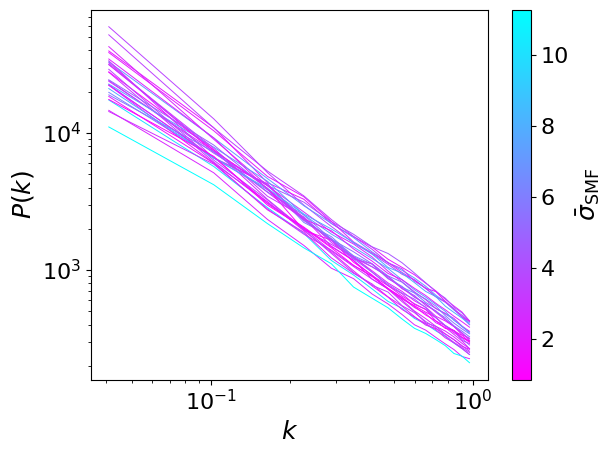

In [21]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [22]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [23]:
emulator = baccoemu.Lbias_expansion()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 w

Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [25]:
# should this match camels??
cosmo_params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [26]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [27]:
def ln_like(free_params, k_data, pk_data, variance,
            nbar, emulator, cosmo_params):
    bias_params = free_params[:4]
    A_sn = free_params[-1]
    _, pk_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data,
                                             **cosmo_params)
    pk_model = pk_gg + A_sn/nbar
    delta_y = pk_data - pk_gg
    lnlk = 0.5 * np.sum((delta_y/variance)**2)
    #lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [28]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [29]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
free_param_names = bias_param_names + ['Asn']
bounds_dict = {'b1': [-5, 20],
                'b2': [-5, 10],
                'bs2': [-10, 20],
                'bl': [-20, 30],
                'Asn': [0, 2],
                }
bounds = [bounds_dict[param_name] for param_name in free_param_names]

In [30]:
n_fit = 1

In [31]:
free_params_0 = [0.5, 0.5, 1.0, -1.0, 1.0]
res_arr = []
var_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    pk_sam = pks[i]['pk'][i_bins]
    
    err_poisson = pks[i]['shotnoise'][i_bins]
    err_1p = 0.01*pk_sam
    variance = err_poisson**2 + err_1p**2
    var_arr.append(variance)

    res = scipy.optimize.minimize(ln_like, free_params_0, bounds=bounds, 
                                  args=(k_sam, pk_sam, variance, nbar_arr[i], emulator, cosmo_params))
    res_arr.append(res)

Fitting SAM 0


In [32]:
print(np.sum([res['success'] for res in res_arr]))

1


In [38]:
np.sqrt(var_arr)

array([[198.8754322 ,  68.7864599 ,  46.4526397 ,  29.20770642,
         25.79731874,  22.72414214,  21.68547301,  20.95977223,
         20.36073061,  20.11933434,  19.80542695,  19.64598926]])

Text(0.5, 0, '$k$')

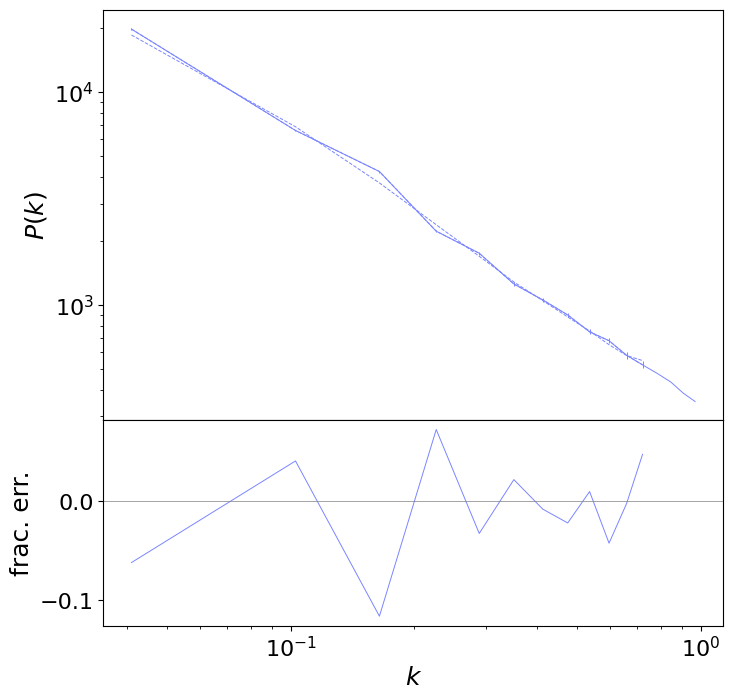

In [36]:
nrows, ncols = 2, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(8,8), sharex=True, height_ratios=[2,1])
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    axarr[0].plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    axarr[0].errorbar(k_sam, pks[i]['pk'][i_bins], yerr=np.sqrt(var_arr[i]), lw=0.7, ls='--', color=colors[i])
    bias_params = res_arr[i]['x'][:4]
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_sam, **cosmo_params)
    axarr[0].plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])
    axarr[0].set_ylabel(r'$P(k)$')
    
    axarr[1].plot(k_sam, (pk_emu-pks[i]['pk'][i_bins])/pks[i]['pk'][i_bins], lw=0.7, color=colors[i])
    axarr[1].set_ylabel('frac. err.')
    axarr[1].axhline(0, color='grey', lw=0.5)

plt.xscale('log')
axarr[0].set_yscale('log')
plt.xlabel(r'$k$')

## Plot bias params

Text(0.5, 0, '$b_1$')

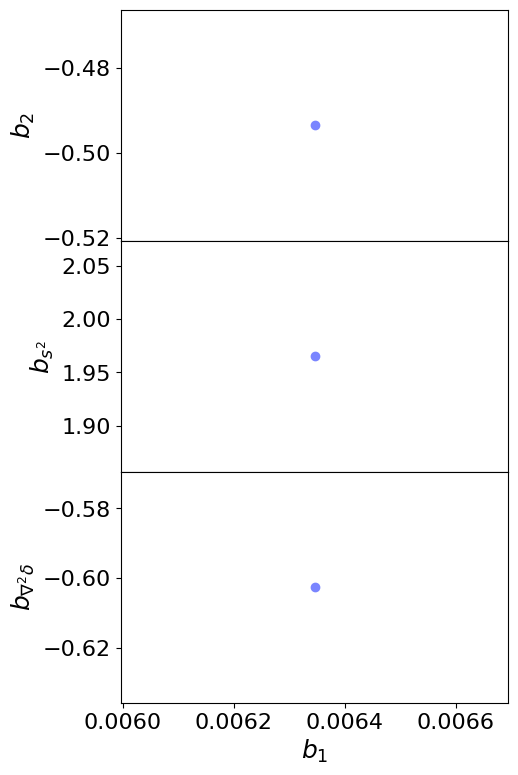

In [34]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])